# Accessing EDAV Data via Web Coverage Service

Authors: Alex Mandel (DevSeed), Samuel Ayers (UAH), Aimee Barciauskas (DevSeed)

Date: April 3, 2023

Description: This example demonstrates how to retrieve raster data from EDAV using a Web Coverage Service (WCS). A WCS lets you access coverage data with multiple dimensions online. The downloaded data is subsetted from data hosted on the MAAP and is available with the full resolution and values.

## Run This Notebook
To access and run this tutorial within MAAP's Algorithm Development Environment (ADE), please refer to the ["Getting started with the MAAP"](https://docs.maap-project.org/en/latest/getting_started/getting_started.html) section of our documentation.

Disclaimer: it is highly recommended to run a tutorial within MAAP's ADE, which already includes packages specific to MAAP, such as maap-py. Running the tutorial outside of the MAAP ADE may lead to errors.

## Additional Resources
- [Raster data handling with Python](https://geoscripting-wur.github.io/PythonRaster/)
- [OWSLib Github](https://github.com/geopython/OWSLib)
- [rioxarray Documentation](https://corteva.github.io/rioxarray)

## Importing and Installing Packages

We start by installing the libraries that are used to query the WCS connection point, and then to load, explore, and plot the raster data. We use `rasterio` for reading and writing raster formats, `rio-cogeo` for creating and validating Cloud Optimized GEOTIFF (COG) data, and `owslib` for interacting with Open Geospatial Consortium (OGC) services.

In [ ]:
# install libraries 
# %pip is a magic command that installs into the current kernel
# -q means quiet (to give less output)
%pip install -q rasterio
%pip install -q rio-cogeo
%pip install -q owslib

After installing the libraries, note that you may see multiple messages that you need to restart the kernel. Then import `rasterio`, `show` from `rasterio.plot` to display images with labeled axes, and `WebCoverageService` from `owslib.wcs` to program with an OGC web service.

In [16]:
# import rasterio
import rasterio as rio
# import show
from rasterio.plot import show
# import WebCoverageService 
from owslib.wcs import WebCoverageService

## Querying the WCS

Now we can configure the WCS source, use the `getCoverage` function to request a file in GeoTIFF format, and save what is returned to our workspace.

In [17]:
# configure the WCS source
EDAV_WCS_Base = "https://edav-das.val.esa-maap.org/wcs"
wcs = WebCoverageService(f'{EDAV_WCS_Base}?service=WCS', version='2.0.0')

In [18]:
# request imagery to download
response = wcs.getCoverage(
    identifier=['ESACCI_Biomass_L4_AGB'], # coverage ID
    format='image/tiff', # format what the coverage response will be returned as
    filter='false', # define constraints on query
    scale=1, # resampling factor (1 full resolution, 0.1 resolution degraded of a factor of 10)
    subsets=[('Long',11.54,11.8),('Lat',-0.3,0.0)] # subset the image by lat / lon
)

# save the results to file as a tiff
results = "EDAV_example.tif"
with open(results, 'wb') as file:
    file.write(response.read())

We can use `gdalinfo` to provide information about our raster dataset to make sure the data is valid and contains spatial metadata.

In [19]:
# gives information about the dataset
!gdalinfo {results}

Driver: GTiff/GeoTIFF
Files: EDAV_example.tif
Size is 293, 339
Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1,
                ID["EPSG",9001]]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433,
            ID["EPSG",9122]]],
    CS[ellipsoidal,2],
        AXIS["latitude",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]],
        AXIS["longitude",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]]]
Data axis to CRS axis mapping: 2,1
Origin = (11.539555555748001,0.000888887639000)
Pixel Size = (0.000888888889000,-0.000888888889000)
Metadata:
  AREA_OR_POINT=Area
  cdm_data_type=INT
  comment=These data were produced at ESA CCI as part of the ESA 

## Reading the Data

We can now use `rio.open` with our `results` path string and return an opened dataset object. We can set a variable (`rast`) to what is read from this dataset object. Then, we utilize the function `show` to display the raster using Matplotlib.

In [20]:
# take path and return opened dataset object, set variable to read dataset object
with rio.open(results, 'r') as src:
        rast = src.read()

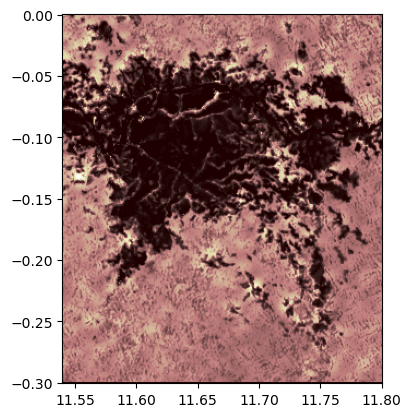

<AxesSubplot: >

In [21]:
# make a plot
show(rast, transform=src.transform, cmap='pink')

We now have a visual of our raster. Let's import and employ the `show_hist` function from `rasterio.plot` to generate a histogram of the raster.

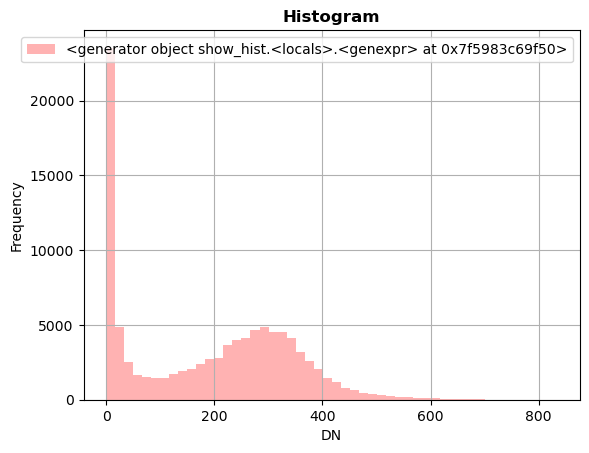

In [22]:
# import show_hist
from rasterio.plot import show_hist
# create histogram
show_hist(rast, 
          bins=50,# number of bins to compute histogram across
          alpha=.3,# transparancy 
          title="Histogram"# figure title
         )

We can also generate a plot using Matplotlib. Let's import `matplotlib.pyplot` and `numpy` and make a new plot. To do this, use the `plt.subplots` function to return a figure and a single "Axes" instance. Then remove single-dimensional entries from the shape of our array using `np.squeeze` and display the data as an image using `imshow`. Now, we can set the norm limits for image scaling using the `set_clim` function.

In [23]:
# import matplotlib.pyplot
import matplotlib.pyplot as plt
# import numpy
import numpy as np

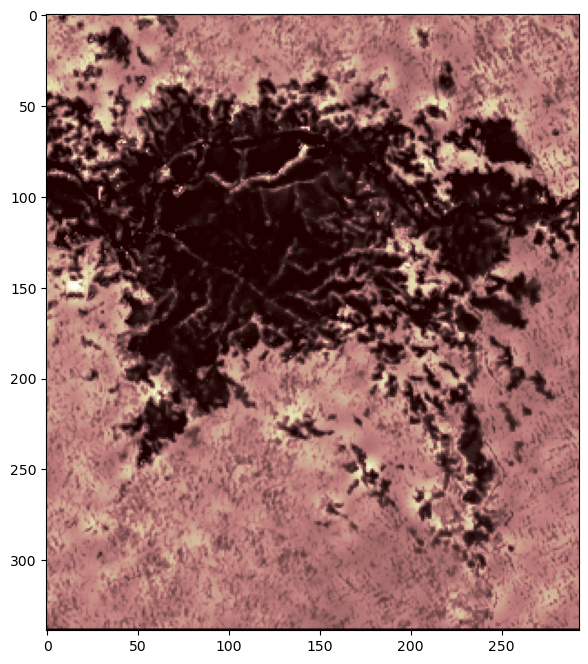

In [24]:
# set figure and single "Axes" instance
fig, ax = plt.subplots(1, figsize=(8,8))
# remove single-dimensional entries from the shape of the variable rast
#     and display the image
edavplot = ax.imshow(np.squeeze(rast), cmap='pink')

## Newer Method `rioxarray`

Another way to work with raster data is with the `rasterio` "xarray" extension. Let's install and import `rioxarray` and create a plot using the `open_rasterio` and `plot` functions.

In [ ]:
# install rasterio xarray extension
%pip install -q rioxarray

In [31]:
# import rasterio xarray extension
import rioxarray

In [32]:
# opens results with rasterio to set dataarray
edav_x = rioxarray.open_rasterio(results)

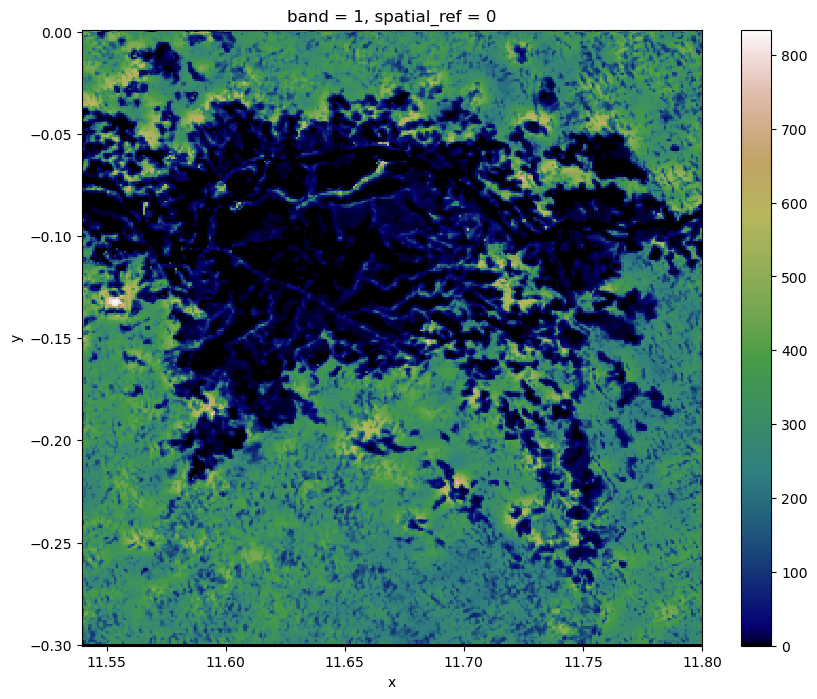

In [33]:
# plot dataarray
edav_x.plot(cmap="gist_earth", figsize=(10,8))